In [2]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/BP_data.csv"
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data)
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [3]:
df.isnull().sum()

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

In [4]:
#결측치
df['Genetic_Pedigree_Coefficient'] = df['Genetic_Pedigree_Coefficient'].fillna(df['Genetic_Pedigree_Coefficient'].mean())
df['alcohol_consumption_per_day'] = df['alcohol_consumption_per_day'].fillna(df['alcohol_consumption_per_day'].median())

In [6]:
X = df.drop(columns=['Blood_Pressure_Abnormality', 'Patient_Number', 'Pregnancy'])
Y = df['Blood_Pressure_Abnormality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42, stratify=Y)

In [7]:
#tensor로 변
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [8]:
#모델링

class BP_Classifier(nn.Module):
    def __init__(self):
        super(BP_Classifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = BP_Classifier()

In [9]:
#손실값으로 optimizer가중치 조절 Adam 사용
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
#실 학습 시작
epochs = 50
train_loss_list = []
test_acc_list = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    
    train_loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        _, preds_class = torch.max(preds, 1)
        acc = (preds_class == y_test).float().mean()
        test_acc_list.append(acc.item())
    
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Test Acc: {acc.item()*100:.2f}%")

Epoch 1/50, Loss: 0.3939, Test Acc: 78.25%
Epoch 2/50, Loss: 0.3917, Test Acc: 78.50%
Epoch 3/50, Loss: 0.3895, Test Acc: 78.75%
Epoch 4/50, Loss: 0.3873, Test Acc: 79.00%
Epoch 5/50, Loss: 0.3850, Test Acc: 79.25%
Epoch 6/50, Loss: 0.3828, Test Acc: 79.75%
Epoch 7/50, Loss: 0.3805, Test Acc: 79.75%
Epoch 8/50, Loss: 0.3782, Test Acc: 80.25%
Epoch 9/50, Loss: 0.3759, Test Acc: 80.25%
Epoch 10/50, Loss: 0.3736, Test Acc: 80.25%
Epoch 11/50, Loss: 0.3714, Test Acc: 80.50%
Epoch 12/50, Loss: 0.3691, Test Acc: 81.00%
Epoch 13/50, Loss: 0.3668, Test Acc: 81.25%
Epoch 14/50, Loss: 0.3645, Test Acc: 81.25%
Epoch 15/50, Loss: 0.3623, Test Acc: 81.75%
Epoch 16/50, Loss: 0.3600, Test Acc: 81.75%
Epoch 17/50, Loss: 0.3577, Test Acc: 81.75%
Epoch 18/50, Loss: 0.3555, Test Acc: 81.50%
Epoch 19/50, Loss: 0.3532, Test Acc: 81.75%
Epoch 20/50, Loss: 0.3509, Test Acc: 81.75%
Epoch 21/50, Loss: 0.3487, Test Acc: 82.00%
Epoch 22/50, Loss: 0.3465, Test Acc: 82.25%
Epoch 23/50, Loss: 0.3442, Test Acc: 82.2

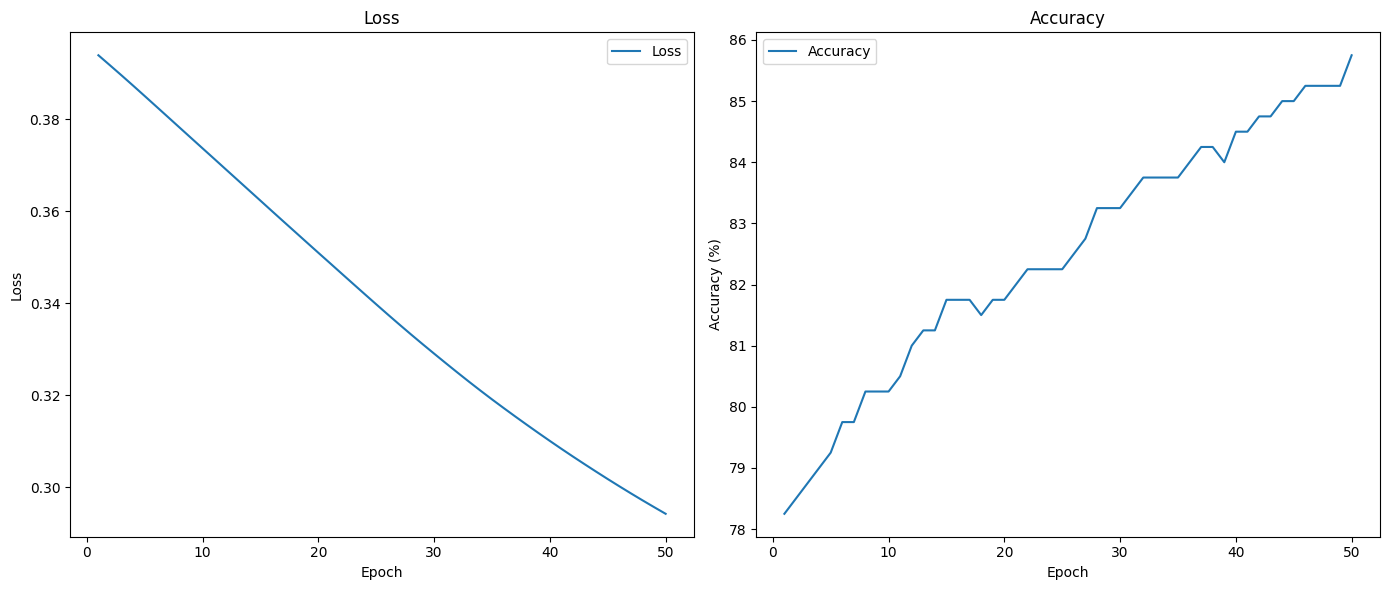

In [17]:
cnt = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cnt, train_loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnt, [acc * 100 for acc in test_acc_list], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()